# Assignment 3: RTRL

RTRL computes the recurrent parts of the gradients during the forward pass already. In this task I will implement RTRL for the fully recurrent network and examine its correctness by gradient checking.

## Task 1: bias gradient

In practice, we add bias units to our networks, i.e. the hidden preactivations are
$$
s_n(t) = \sum_{l=1}^D w_{l n} x_l(t) + \sum_{k=1}^I r_{kn} f(s_k(t-1)) + b_n\ .
$$
Compute the recursive form of the bias gradient
$$
\begin{aligned}
\frac{\partial s_n(t)}{\partial b_i} &= 1 + \sum_{k=1}^I r_{kn} f´(s_k(t-1))\frac{\partial s_k(t-1)}{\partial b_i}
\end{aligned}
$$

## Task 2: implementation of RTRL

Implement RTRL in the methods `forward()` and `backward()` for the class `RNN` below. Note that RTRL computes a considerable part of the gradients in the forward pass alread. Be sure to use online learning, i.e. a mini-batch size of 1. Use the `check_gradients()` method to check if your implementation of the analytical gradients is correct. Note that the gradients have the shape of the weights transposed. 

python version: 3.9.12
numpy version: 1.21.5
numpy version: 3.5.1


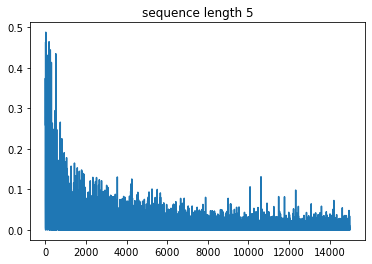

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

print('python version: 3.9.12')
print('numpy version:',np.__version__)
print('numpy version:',matplotlib.__version__)

class RNN(object):
    def __init__(self, n_input, n_hidden, n_output):
        # init weights and biases
        self.n_input = n_input
        self.n_hidden = n_hidden
        self.n_output = n_output
        self.W = np.random.normal(scale=0.1, size=(n_input, n_hidden))
        self.R = np.eye(n_hidden)
        self.V = np.random.normal(scale=0.1, size=(n_hidden, n_output))
        self.bh = np.zeros((n_hidden, 1))
        self.bo = np.zeros((n_output, 1))
        self.reset()
    
    
    def reset(self):
        # init hidden activation
        self.s = np.zeros((self.n_hidden, 1))
        self.a_t = np.zeros((self.n_hidden, 1))
        
        # init buffers for recursive gradients
        self.ds_dW = np.zeros((self.n_hidden, self.n_hidden * self.n_input))
        self.ds_dR = np.zeros((self.n_hidden, self.n_hidden * self.n_hidden))
        self.ds_db = np.zeros((self.n_hidden, self.n_hidden))
    
    def forward(self, x):
        assert(x.shape[1] == self.n_input)
        assert(len(x.shape) == 2)

        x = x.T                  
        self.ds_dR = np.kron(self.a_t.T,np.eye(self.R.shape[1])) + self.R.T @ (np.diag(np.diag(1 - self.a_t@self.a_t.T))) @ self.ds_dR
        self.ds_dW = np.kron(x.T,np.eye(self.W.shape[1])) + self.R.T @ (np.diag(np.diag(1 - self.a_t@self.a_t.T))) @ self.ds_dW
        
        self.s = self.W.T @ x + self.R.T @ np.tanh(self.s) + self.bh
        self.a_t = np.tanh(self.s)
        pred = self.V.T @ self.a_t + self.bo
   
        return pred
                
    
    def backward(self, y_hat, y):
        assert(len(y_hat.shape) == 2)
        assert(y_hat.shape == y.T.shape)
        y = y.T
        
        # compute loss (halved squared error)
        loss = np.sum(0.5 * (y - y_hat)**2)
        
        dloss = -1 * np.sum(y - y_hat,axis = 1)
        dloss = np.expand_dims(dloss, axis=1)
        
        self.grad_bo = dloss.T 
        self.grad_V = dloss @ self.a_t.T
        
        d_a = self.V @ dloss
        ds = d_a.T @ np.diag(np.diag(1 - self.a_t@self.a_t.T))
        
        self.grad_R = ds @ self.ds_dR
        self.grad_R = self.grad_R.reshape((self.n_hidden,self.n_hidden),order = 'F')
        
        self.grad_W = ds @ self.ds_dW
        self.grad_W = self.grad_W.reshape((self.n_hidden, self.n_input),order = 'F')
        
        return loss
    
    
    def fast_forward(self, x_seq):
        # this is a forward pass without gradient computation for gradient checking
        s = np.zeros_like(self.s)
        
        for x in x_seq:
            s = self.W.T @ x.reshape(*x.shape, 1) + self.R.T @ np.tanh(s) + self.bh
        
        return self.V.T @ np.tanh(s) + self.bo
    
    
    def gradient_check(self, x, y, eps=1e-5, thresh=1e-5, verbose=True):
        params = (self.W, self.R, self.V,self.bo)
        gana = (self.grad_W, self.grad_R, self.grad_V,self.grad_bo)
        gnum = (np.zeros_like(g) for g in gana)
        names = ('W', 'R', 'V','bo')
        diff = 0.
        
        for w, gn, ga, name in zip(params, gnum, gana, names):
            

            
            for i in range(w.shape[0]):
                for j in range(w.shape[1]):
                    w_orig = w[i,j]
                    w[i,j] = w_orig + eps/2
                    hi = np.sum(0.5 * (y - self.fast_forward(x))**2)
                    w[i,j] = w_orig - eps/2
                    lo = np.sum(0.5 * (y - self.fast_forward(x))**2)
                    w[i,j] = w_orig
                    gn[j,i] = (hi - lo) / eps
                    
                    dev = abs(gn[j,i] - ga[j,i])
                    
                    
                    assert(dev < thresh)
    
    
    def update(self, eta):
        # update weights
        self.bo -= eta * self.grad_bo.T
        self.V  -= eta * self.grad_V.T
        self.W  -= eta * self.grad_W.T
        self.R  -= eta * self.grad_R.T


def generate_samples(seq_length, batch_size, input_size):
    while True:
        x = np.random.uniform(low=-1, high=1, size=(seq_length, batch_size, input_size))
        y = x[0,:,:]
        yield x, y


def check_gradients():
    rnn = RNN(2, 5, 2)
    data = generate_samples(seq_length=10, batch_size=1, input_size=2)
    
    for i, (x, y) in zip(range(1), data):
        rnn.reset()
        
        for x_t in x:
            y_hat = rnn.forward(x_t)
            
        
        rnn.backward(y_hat, y)
        rnn.gradient_check(x, y.T)


def train(iter_steps_user = 15000,lr_user = 1e-2,seq_length_user = 5):
    iter_steps = iter_steps_user
    lr = lr_user
    seq_length = seq_length_user
    
    rnn = RNN(1, 10, 1)
    data = generate_samples(seq_length=seq_length, batch_size=1, input_size=1)
    loss = []

    for i, (x, y) in zip(range(iter_steps), data):
        rnn.reset()
        for x_t in x:
            y_hat = rnn.forward(x_t)

        loss.append(rnn.backward(y_hat, y))
        rnn.update(lr)

    # plot learning curve
    plt.title('sequence length %d' % seq_length)
    plt.plot(range(len(loss)), loss)
    plt.show()


check_gradients()
train()